In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
# data of brain MRI and corresponding mask
df_brain = pd.read_csv('data_mask.csv')

In [21]:
# convert data in mask column to string format, to use categorical mode in flow_from_dataframe
df_brain['mask'] = df_brain['mask'].astype(str)

In [22]:
# split the data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_brain, test_size=0.15, random_state=12345)

In [23]:
# create an image generator
from keras_preprocessing.image import ImageDataGenerator

# create a data generator which scales the data from 0 to 1 and make validation split
datagen = ImageDataGenerator(rescale=1./255., 
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

In [34]:
train_generator = datagen.flow_from_dataframe(
                    dataframe=train,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    subset='training',
                    batch_size=16,
                    shuffle=True, # shuffle the data so the order is not used as information for training
                    class_mode='categorical',
                    target_size=(256,256))

valid_generator = datagen.flow_from_dataframe(
                    dataframe=train,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    subset='validation',
                    batch_size=16,
                    shuffle=True,
                    class_mode='categorical',
                    target_size=(256,256))

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
                    dataframe=test,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    batch_size=16,
                    shuffle=False, # no need to shuffle the test data as we don't use it for training
                    class_mode='categorical',
                    target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [43]:
# define model
model = Sequential()
# Convolutiom
model.add(Conv2D(32, 3, 3, input_shape=(256, 256, 3), activation='relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flattening
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 85, 85, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 42, 42, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               14450944  
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                

In [48]:
# Train the model

#define callbacks
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10, restore_best_weights=True)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier_resnet_weights_cnn.hdf5', 
                               verbose=1, save_best_only=True)

In [44]:
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n//16,
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//16,
                    callbacks=[checkpointer, earlystopping])

Train for 177 steps, validate for 31 steps
Epoch 1/100
176/177 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.7421
Epoch 00001: val_loss improved from inf to 0.49186, saving model to classifier_resnet_weights_nn.hdf5
177/177 [==============================] - 60s 337ms/step - loss: 0.5286 - accuracy: 0.7421 - val_loss: 0.4919 - val_accuracy: 0.7681
Epoch 2/100
176/177 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.7834
Epoch 00002: val_loss improved from 0.49186 to 0.37742, saving model to classifier_resnet_weights_nn.hdf5
177/177 [==============================] - 59s 331ms/step - loss: 0.4354 - accuracy: 0.7832 - val_loss: 0.3774 - val_accuracy: 0.7984
Epoch 3/100
176/177 [============================>.] - ETA: 0s - loss: 0.3901 - accuracy: 0.8044
Epoch 00003: val_loss improved from 0.37742 to 0.36008, saving model to classifier_resnet_weights_nn.hdf5
177/177 [==============================] - 59s 332ms/step - loss: 0.3903 - accuracy:

In [49]:
model.save('classifier_resnet_weights_cnn.hdf5')

In [50]:
# make prediction
test_predict = model.predict(test_generator, #steps=test_generator.n//16, 
                             verbose=1)
test_predict

37/37 [==============================] - 3s 74ms/step


array([[1.0000000e+00, 2.7831680e-08],
       [3.7984666e-03, 9.9620157e-01],
       [3.9889098e-08, 1.0000000e+00],
       ...,
       [1.0000000e+00, 6.7971605e-13],
       [9.9921370e-01, 7.8628946e-04],
       [9.8339578e-06, 9.9999022e-01]], dtype=float32)

In [51]:
"""Model evaluation"""
# obtain the predicted class from model prediction (probability)
y_predict = []
for i in test_predict:
    y_predict.append(str(np.argmax(i)))
y_predict = np.asarray(y_predict)
y_predict[:10]

array(['0', '1', '1', '1', '0', '0', '1', '0', '1', '0'], dtype='<U1')

In [52]:
y_test = np.asarray(test['mask'])[:len(test_predict)]
y_test[:10]

array(['0', '1', '1', '1', '0', '0', '1', '0', '1', '0'], dtype=object)

0.9169
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       381
           1       0.92      0.84      0.88       209

    accuracy                           0.92       590
   macro avg       0.92      0.90      0.91       590
weighted avg       0.92      0.92      0.92       590



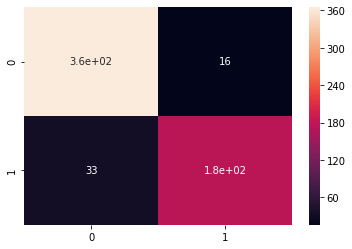

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_predict)
print('%.4f'%accuracy)

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

print(classification_report(y_test, y_predict))